In [190]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 

from utils import *

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

In [191]:
path_data = 'data/pump_sensor.csv'

In [192]:
import pandas as pd

datafull=pd.read_csv(path_data)

data = datafull.iloc[:,2:-1]

print(data.shape)
print(data.keys())

(220320, 52)
Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51'],
      dtype='object')


In [193]:
data.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889


In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 52 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sensor_00  210112 non-null  float64
 1   sensor_01  219951 non-null  float64
 2   sensor_02  220301 non-null  float64
 3   sensor_03  220301 non-null  float64
 4   sensor_04  220301 non-null  float64
 5   sensor_05  220301 non-null  float64
 6   sensor_06  215522 non-null  float64
 7   sensor_07  214869 non-null  float64
 8   sensor_08  215213 non-null  float64
 9   sensor_09  215725 non-null  float64
 10  sensor_10  220301 non-null  float64
 11  sensor_11  220301 non-null  float64
 12  sensor_12  220301 non-null  float64
 13  sensor_13  220301 non-null  float64
 14  sensor_14  220299 non-null  float64
 15  sensor_15  0 non-null       float64
 16  sensor_16  220289 non-null  float64
 17  sensor_17  220274 non-null  float64
 18  sensor_18  220274 non-null  float64
 19  sensor_19  220304 non-n

In [195]:
''' 
Get some info on the target-data
'''

print( 'status options: ');  print( datafull['machine_status'].unique()); print() # Get the unique values for class
print (datafull['machine_status'].value_counts()); print() # Count the Classes to see how many we got from each

status options: 
['NORMAL' 'BROKEN' 'RECOVERING']

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64



In [196]:
'''
Convert the classes from string to values by using the scikit-learn mapper
'''

le = preprocessing.LabelEncoder() #get the label Encoder
le.fit(datafull.machine_status) #fit it to the data that the encoder knows what to do
encoded_y=le.transform(datafull.machine_status) #finally transform the data and put it into a pandas data frame for easier use

#Get the Label map
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) # To be able to later indentify what is what, create a label map
print(le_name_mapping)

{'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


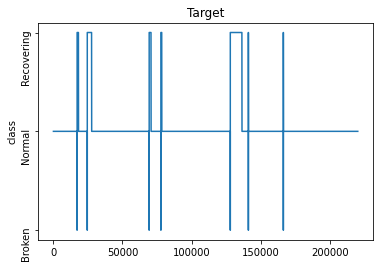

In [197]:
'''
Plot the  target data
'''

x = np.linspace(1, len(encoded_y), len(encoded_y))# create x-axis (could also be the converted timestamp column)
plt.plot(x, encoded_y) 
plt.ylabel('class')
plt.title('Target')
labels = ['Normal','Broken','Recovering'] # Give the y-axis the Class lables we found earlier
plt.yticks([1,0,2], labels, rotation='vertical') # Set the y-ticks to three to only show the classnames
plt.show()  

In [198]:
datafull['machine_status'].loc[datafull['machine_status'] =='BROKEN'] = 0
datafull['machine_status'].loc[datafull['machine_status'] =='NORMAL'] = 1
datafull['machine_status'].loc[datafull['machine_status'] =='RECOVERING'] = 2

In [199]:
datafull['machine_status'].value_counts()

1    205836
2     14477
0         7
Name: machine_status, dtype: int64

#### Rimuoviamo le righe duplicate

In [200]:
data.drop_duplicates(inplace=True)
datafull.drop_duplicates(inplace=True)

#### Removing NaNs

Text(0.5, 1.0, 'Count NaN')

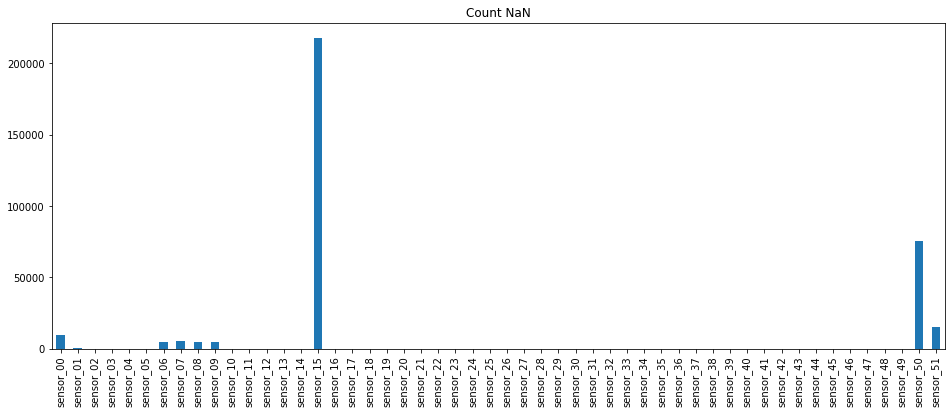

In [201]:
plt.figure(figsize=(16,6))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')
plt.title('Count NaN')

Text(0.5, 1.0, 'Removing Sensor 15')

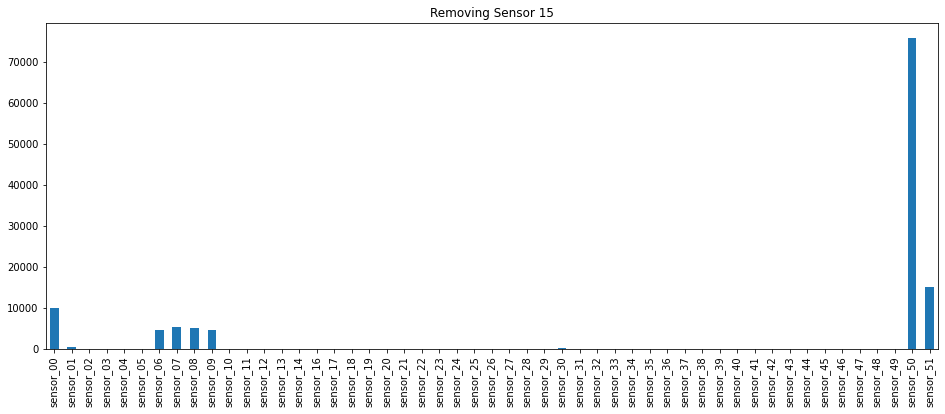

In [202]:
plt.figure(figsize=(16,6))

data.drop('sensor_15', inplace=True, axis=1)
datafull.drop('sensor_15', inplace=True, axis=1)

data.isna().sum()[data.isna().sum()>0].plot(kind='bar')
plt.title('Removing Sensor 15')

Text(0.5, 1.0, 'Focus sensos 50')

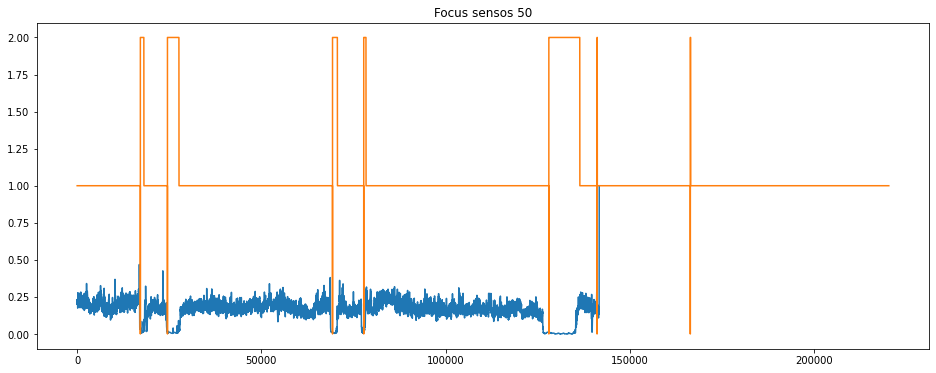

In [203]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(16,6))

scaler = MinMaxScaler()
scaled_dat = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
plt.plot(scaled_dat.sensor_50)

x = np.linspace(1, len(encoded_y), len(encoded_y))# create x-axis (could also be the converted timestamp column)
plt.plot(x, encoded_y)
plt.title('Focus sensos 50')


Text(0.5, 1.0, 'Focus sensos 51')

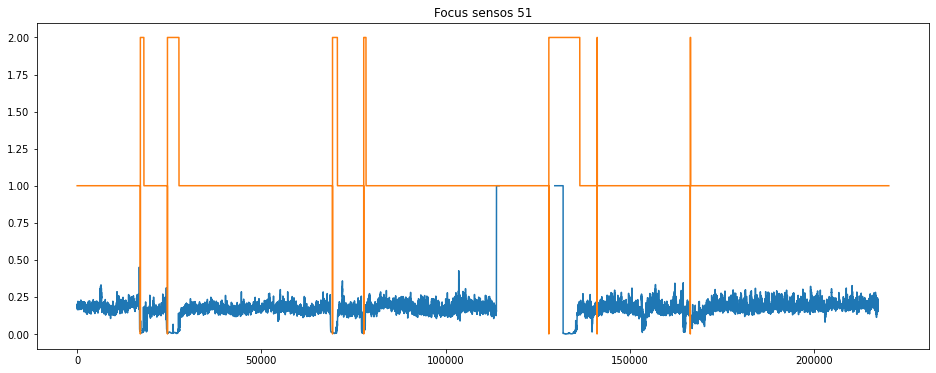

In [204]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(16,6))

scaler = MinMaxScaler()
scaled_dat = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
plt.plot(scaled_dat.sensor_51)

x = np.linspace(1, len(encoded_y), len(encoded_y))# create x-axis (could also be the converted timestamp column)
plt.plot(x, encoded_y) 
plt.title('Focus sensos 51')


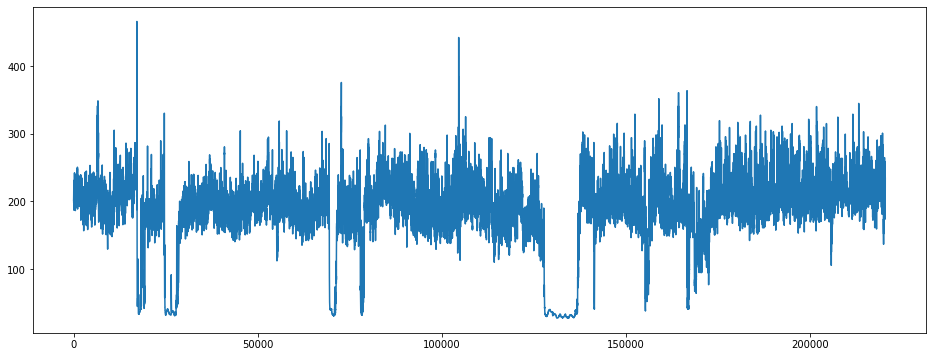

In [205]:
plt.figure(figsize=(16,6))

# repair sensor 50 with 51 data
data.sensor_51[110000:140000]=data.sensor_50[110000:140000] # repair sensor 51
datafull.sensor_51[110000:140000]=datafull.sensor_50[110000:140000] # repair sensor 51

# drop sensor 50
data.drop('sensor_50', inplace=True, axis=1)
datafull.drop('sensor_50', inplace=True, axis=1)

plt.plot(data.sensor_51)

In [206]:
data.columns

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_51'],
      dtype='object')

Text(0.5, 1.0, 'Dropped sensor 15, 50 and fixed 51')

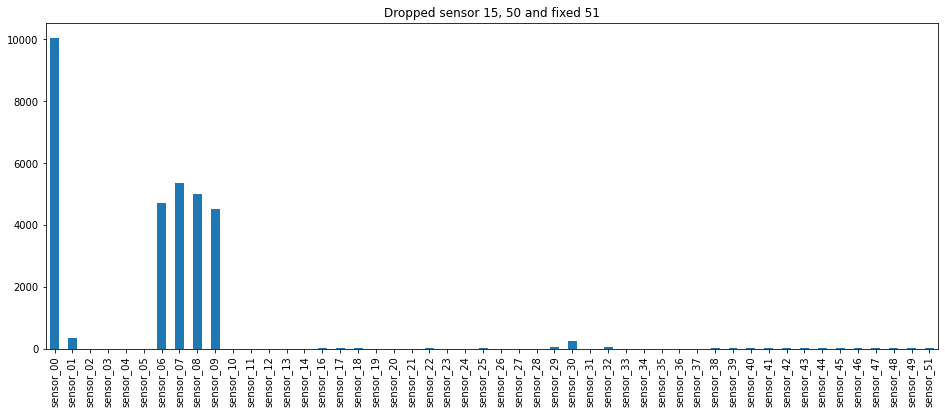

In [207]:
plt.figure(figsize=(16,6))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')
plt.title('Dropped sensor 15, 50 and fixed 51')

<AxesSubplot:title={'center':'Var'}>

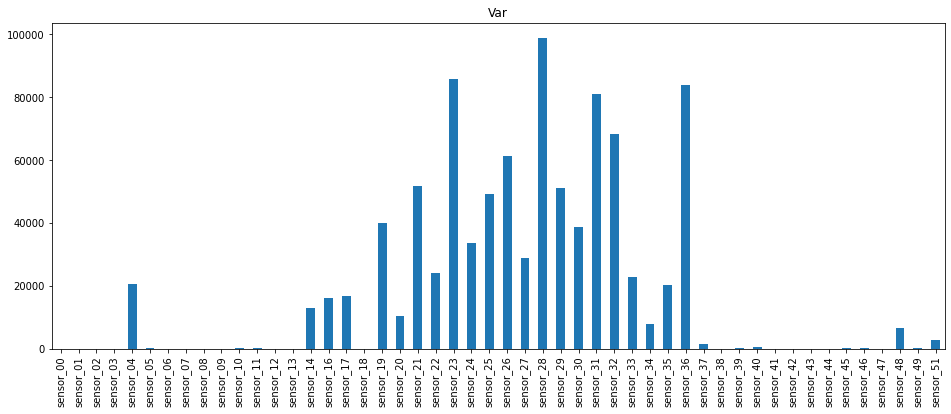

In [208]:
plt.figure(figsize=(16,6))
plt.title('Var')
data.var().plot(kind='bar')

si osserva come i senso 00 e 06-09 pur avendo dei valori mancando non hanno molta varianza, pe cui dediciamo allora di rimuoverli siccome non penso portino molta informzione

<AxesSubplot:>

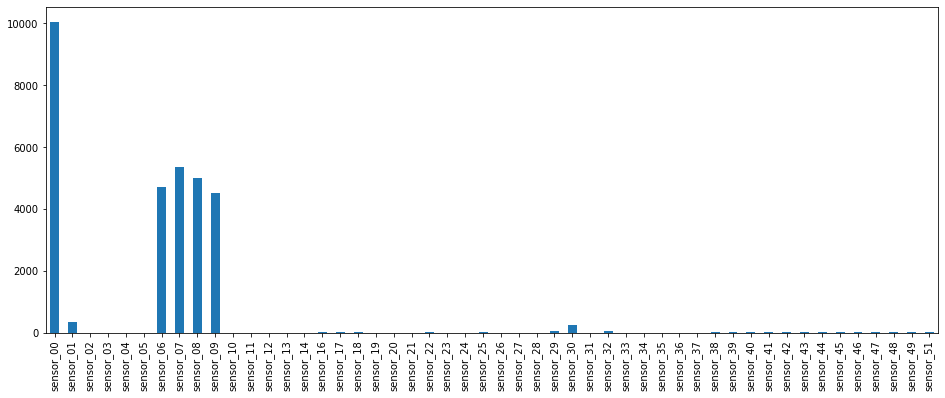

In [209]:
plt.figure(figsize=(16,6))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')

In [210]:
datafull['machine_status'].loc[(datafull['machine_status'] == 0) | (datafull['machine_status'] == 2) ] = 0

In [211]:
def plot_missing (sensor_num, df):
    """
    Function to plot machine status, sensor readings variation with time
    Also to plot missing values
    """
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[[sensor_num]])
    null_sensor = df[df[sensor_num].isnull()][sensor_num]

    plt.figure(figsize=(10, 4))
    plt.plot(list(df.index), list(scaled), label='readings')
    plt.scatter(list(null_sensor.index), [0]*len(null_sensor.index), 
                color = 'red', label='missing values')
    
    # reversing labels for better visualization
#    y = list(data['machine_status'].map(lambda label:  1 if label == 0 else 0))
    plt.plot(list(df.index), datafull['machine_status'], color = 'green', label='machine status')

    encode_labels = [1, 0] # encodedù labels
    labels = ['NORMAL', 'BROKEN'] # labels
    plt.yticks(encode_labels, labels)

    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel(f'{sensor_num} readings')
    plt.title(f'{sensor_num} readings vs Time')
    plt.show()

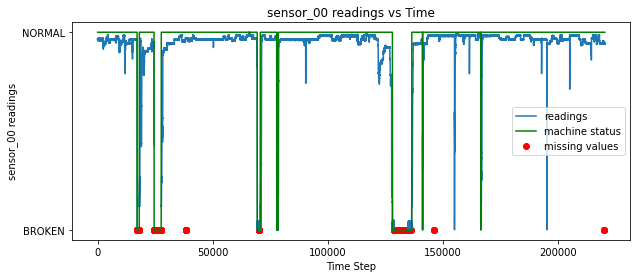

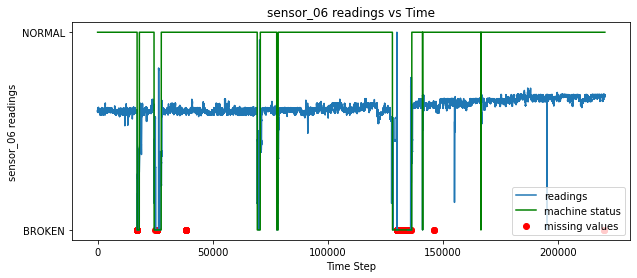

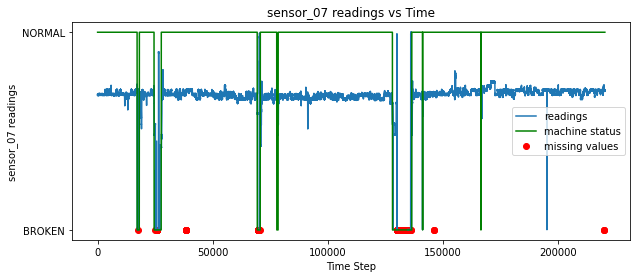

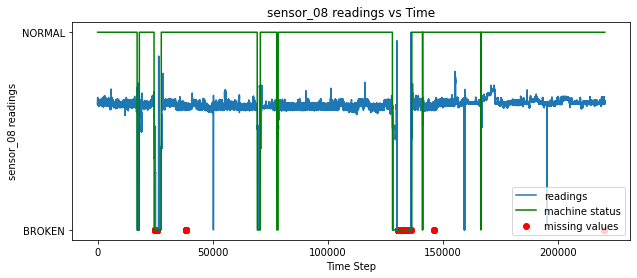

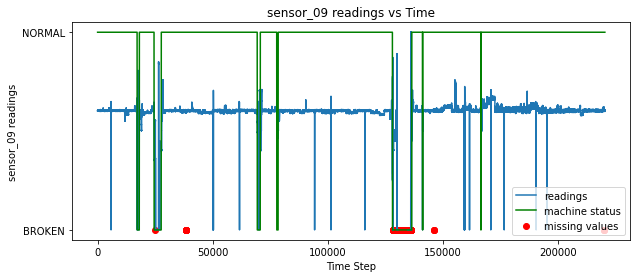

In [212]:
for s in ["sensor_00", "sensor_06", "sensor_07", "sensor_08", "sensor_09"]:
    plot_missing(s, datafull)

In [220]:
datafull.drop(["sensor_06","sensor_07","sensor_08","sensor_09" ], axis=1).dropna()['machine_status'].value_counts()

1    205067
0      4290
Name: machine_status, dtype: int64

In [221]:
datafull.dropna()['machine_status'].value_counts()

1    205067
0      3718
Name: machine_status, dtype: int64

In [172]:
"""
plt.figure(figsize=(16,6))

data.fillna(method="pad", limit=30, inplace=True) # fill degli na con PAD mode e fino a 30 na consecutivi, il resto lascia na
data.dropna(inplace=True)

datafull.fillna(method="pad",limit=30, inplace=True) # fill degli na con PAD mode e fino a 30 na consecutivi, il resto lascia na
datafull.dropna(inplace=True)
"""

plt.figure(figsize=(16,6))

#data.fillna(-1, inplace=True) # fill degli na con PAD mode e fino a 30 na consecutivi, il resto lascia na
data.dropna(inplace=True)
#data=data.fillna(method="pad",limit=250) # fill up to 30 consecutive  NaNs 
#data.dropna(inplace=True)


#datafull.fillna(-1, inplace=True)
datafull.dropna(inplace=True)
#datafull=datafull.fillna(method="pad",limit=150) # fill up to 30 consecutive  NaNs 
#datafull.dropna(inplace=True)


<Figure size 1152x432 with 0 Axes>

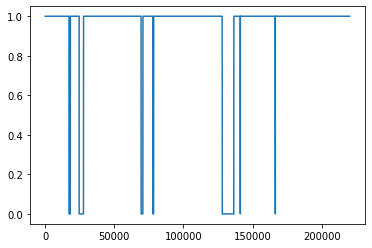

In [173]:
plt.plot(datafull.machine_status)

#### Feature Engineering

In [174]:
datafull.reset_index(inplace=True)
datafull.drop('id', inplace=True, axis=1)

In [175]:
datafull.head()

,index,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,1
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,1
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,1
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,1
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,1


Moreover, plot of machine status variation with time shows that Recovering state follows Broken state and in Recovering state pump is trying to recover from Broken state so Recovering state is considered as Broken state.

In [176]:

datafull['machine_status'].loc[(datafull['machine_status'] == 0) | (datafull['machine_status'] == 2) ] = 0

In [177]:
datafull['machine_status'].value_counts()

1    205067
0      3718
Name: machine_status, dtype: int64

Because of limited availability data, selected time window of 10 minute for prediction i. e. given a data point predict the machine status after 10 minute. Therefore data is pre-processed by shifting the labels by 10 minute.

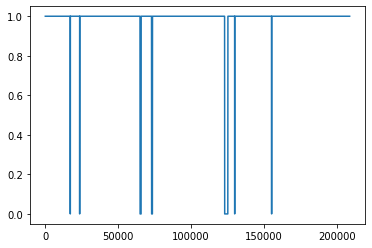

In [178]:
plt.plot(datafull.machine_status)

In [179]:
def shift_labels(sensor_list, df):
    """
    Function to shift labels by 10 min
    """
    #count = 0

    new_features = {}

    for sensor in sensor_list:
        new_features[sensor] = df[sensor]

    labels = [None] * df.shape[0]

    for i in range(0, df.shape[0]-10):
        #print (count)
        #count+=1
        labels[i] = datafull['machine_status'][i+10]
    
    new_features['machine_status'] = labels
    new_df = pd.DataFrame(new_features)
    
    # dropping last rows with null value
    new_df.drop(new_df.tail(10).index,inplace=True)
    return new_df


In [180]:
data_10min_shift = shift_labels(datafull.columns[2:-1], datafull)
data_10min_shift.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,1.0
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,1.0
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,1.0
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,1.0
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,1.0


#### Feauture Selection

For selecting best features, distribution of sensor readings corresponding to Normal class and Broken class is plotted

In [181]:
# Optione 1

<AxesSubplot:>

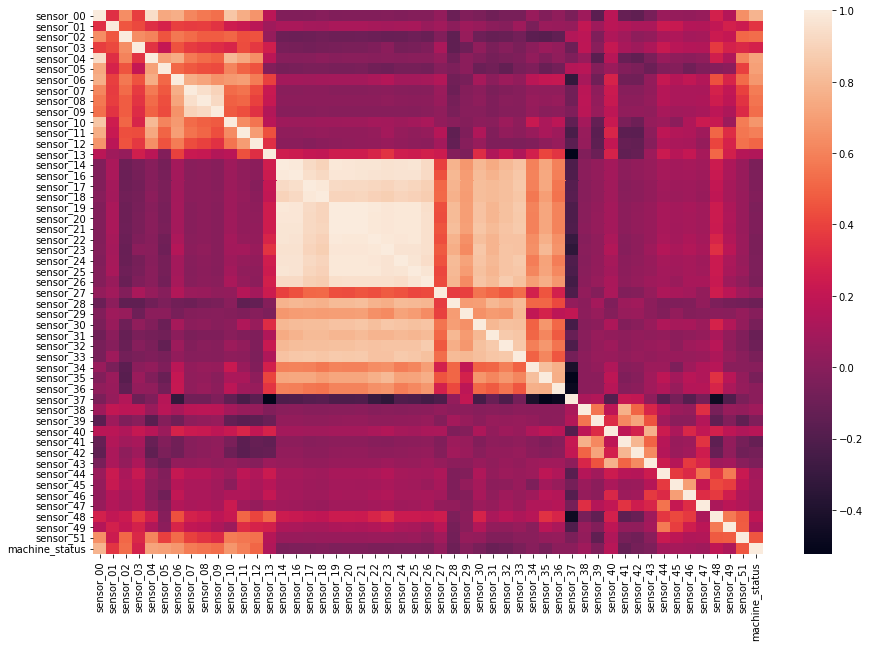

In [182]:
data_corr = data_10min_shift.corr()
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(data_corr)

In [183]:
data_corr['machine_status'].loc[data_corr['machine_status']>0.7]

sensor_00         0.782203
sensor_04         0.722040
sensor_05         0.706086
machine_status    1.000000
Name: machine_status, dtype: float64

In [184]:
def get_distrib_plot(sensor, df):
    """
    Function to plot distribution of sensor readings for Normal and Broken state
    """
    
    # sensor values corrensponding machine status Normal
    normal = df[df['machine_status']==1][sensor].values
    
    # sensor values corrensponding machine status Broken
    broken = df[df['machine_status']==0][sensor].values

    plt.figure(figsize=(10,3))
    # distribution for normal state
    sns.distplot(normal, hist=False, label="Normal") 
    # distribution for broken state
    sns.distplot(broken, hist=False, label="Broken") 
    plt.title('Distribution of sensor readings corresponding Normal and Broken state')
    plt.xlabel(f'{sensor} readings')
    plt.legend()
    plt.show()

In [185]:
#for i in datafull.columns[2:-1]:
#for i in datafull.columns[2:-1]:
#    get_distrib_plot(i, data_10min_shift)

In [186]:
#final_sensors = ['sensor_04', 'sensor_19', 'sensor_20', 'sensor_21', 
#                 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 
#                 'sensor_42']

final_sensors = ['sensor_00', 'sensor_02', 'sensor_04', 'sensor_06',  'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_51' ]

In [187]:
def get_new_features(sensor_list, df):
    """
    Function to find distance from normal state mean value 
    """
    new_features = {}
    for sensor in sensor_list:
        val = df[sensor] - np.mean(df[df['machine_status']==1][sensor].values)
        new_features[sensor] = val
    new_features['machine_status'] = df['machine_status']
    new_df = pd.DataFrame(new_features)
    return new_df

In [188]:
# dist from mean of normal state
df_dist_from_norm_mean = get_new_features(final_sensors, data_10min_shift)
df_dist_from_norm_mean

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,machine_status
0,0.045434,1.57934,8.758089,-0.453763,-0.034163,0.089913,-0.032542,-7.029266,2.770839,4.999103,1.0
1,0.045434,1.57934,8.758089,-0.453763,-0.034163,0.089913,-0.032542,-7.029266,2.770839,4.999103,1.0
2,0.024774,1.57934,13.271989,-0.540573,-0.128193,0.140553,-0.075942,-6.388896,3.423849,7.313903,1.0
3,0.040514,1.53594,2.508089,-0.547803,0.081587,0.220123,-0.003602,-5.676896,3.902689,6.735203,1.0
4,0.025758,1.57934,10.841389,-0.511633,0.045417,0.220123,-0.003602,-4.767276,4.309599,4.999103,1.0
...,...,...,...,...,...,...,...,...,...,...,...
208770,-0.015562,-1.11163,1.350689,1.253407,0.443277,0.176713,-0.025312,-4.443516,5.032619,7.313903,1.0
208771,-0.015562,-1.06822,10.650389,1.224477,0.537317,0.256293,-0.003602,-4.023136,4.947319,7.313903,1.0
208772,-0.019497,-1.11163,-9.297411,1.253407,0.486677,0.292463,-0.032542,1.590774,5.755069,5.867103,1.0
208773,-0.015562,-1.06822,2.045137,1.253407,0.443277,0.292463,-0.112112,-1.950906,7.448479,4.420403,1.0


#### Save processed data

In [189]:
df_dist_from_norm_mean.to_csv('data/pump_sensors_processed.csv', index=False)

#### Splitting the data

In [44]:
def percentage_cls_distrib(df):
    """
    function to get % class distribution among train and test data
    """
    total = len(df)
    class_0 = round(df.value_counts()[0] *100 / total, 2)
    class_1 = round(df.value_counts()[1] *100 / total, 2)
    print(f"% Broken class data points = {class_0}")
    print(f"% Normal class data points= {class_1}")

In [83]:
"""
train, test = train_test_split(df_dist_from_norm_mean)

X_train = train.drop(["machine_status"], axis=1)
X_test = test.drop(["machine_status"], axis=1)
y_train = train[["machine_status"]]
y_test = test[["machine_status"]]
"""
    

# y data
data_y = df_dist_from_norm_mean['machine_status']
# x data
data_x = df_dist_from_norm_mean.drop(columns='machine_status')

train_dataPoints = 130000  # 131000

X_train = data_x[:train_dataPoints]
y_train = data_y[:train_dataPoints]

X_test = data_x[train_dataPoints: ]
y_test = data_y[train_dataPoints: ]


In [84]:
print("Training data")
print()
percentage_cls_distrib(y_train)

Training data

% Broken class data points = 6.11
% Normal class data points= 93.89


In [85]:
print("Test data")
print()
percentage_cls_distrib(y_test)

Test data

% Broken class data points = 7.24
% Normal class data points= 92.76


In [86]:
X_train.shape

(130000, 10)

In [87]:
X_test.shape

(90310, 10)

#### Scaling the Data

In [88]:
def normalize_df(df_train, df_test):
    """
    Function to normalize the data using minimax scaler
    """
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(df_train.values)
    scaled_test = scaler.transform(df_test.values)
    train = pd.DataFrame(data=scaled_train, 
                         columns=df_train.columns, 
                         index=df_train.index)
    test = pd.DataFrame(data=scaled_test, 
                        columns=df_test.columns, 
                        index=df_test.index)
    return train, test

In [89]:
X_train, X_test = normalize_df(X_train, X_test)

In [90]:
X_train.head()

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51
0,0.976438,0.950534,0.793227,0.619817,0.698958,0.681570,0.694111,0.495772,0.795479,0.433246
1,0.976438,0.950534,0.793227,0.619817,0.698958,0.681570,0.694111,0.495772,0.795479,0.433246
2,0.970617,0.950534,0.798863,0.616083,0.695122,0.683654,0.692235,0.504077,0.806184,0.438201
3,0.975052,0.949773,0.785424,0.615772,0.703681,0.686927,0.695363,0.513311,0.814034,0.436962
4,0.970894,0.950534,0.795828,0.617328,0.702205,0.686927,0.695363,0.525107,0.820705,0.433246


In [91]:
X_test.head()

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51
130000,0.0,0.675048,0.005414,0.044253,0.981406,0.996429,1.003753,0.012969,0.016393,0.071514
130001,0.0,0.675048,0.005226,0.044253,0.985243,0.993155,0.993119,0.012969,0.016393,0.071514
130002,0.0,0.675809,0.005031,0.044253,0.971077,0.996429,0.993119,0.012969,0.016393,0.071514
130003,0.0,0.675809,0.005175,0.044253,0.988785,0.996429,0.993119,0.012969,0.016393,0.071514
130004,0.0,0.675809,0.005558,0.044253,0.984948,0.989287,1.000000,0.012969,0.016393,0.071514


#### Modeling

In [92]:
# time splitting of the data for cross validation
folds = TimeSeriesSplit(n_splits=5)

In [93]:
def get_cv_plot(validation, parameter):
    """
    Function to plot cross validation metric
    """
    # creating dataframe of cross validation results
    results = pd.DataFrame.from_dict(validation.cv_results_)
    results = results.sort_values([parameter])

    # Get Mean score for each grid search for train data
    train_macro_f1= validation.cv_results_['mean_train_score']
    # Get Mean score for each grid search for cross validation data
    cv_macro_f1 = validation.cv_results_['mean_test_score'] 
    C =  results[parameter]

    # plotting the results
    plt.figure(figsize=(7,4))
    plt.plot(C, train_macro_f1, label='Train macro f1')
    plt.plot(C, cv_macro_f1, label='CV macro f1')
    plt.scatter(C, train_macro_f1, label='Train macro f1 points')
    plt.scatter(C, cv_macro_f1, label='CV macro f1 points')

    plt.xscale('log')
    plt.legend()
    plt.xlabel("hyperparameter")
    plt.ylabel("macro f1-score")
    plt.title("Macro f1-score Vs Hyperparameter")
    plt.grid( linestyle='-', linewidth=0.5)
    plt.grid()
    plt.show()

In [94]:
def get_confusion_mat( y_true , y_pred):
    """
    Function to plot confusion matrix
    """
    # counfusion matrix
    confusion_mat = confusion_matrix(y_true , y_pred)
        
    labels = ["Broken", "Normal"]

    # plot heat map of confusion matrix
    sns.heatmap(confusion_mat, annot=True, fmt='', cmap='Greens',
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


In [95]:
def get_result( model , x_test , y_test ):
    """
    Function to check model performance on test data and print the metric
    """
    # prediction on test data
    y_pred = model.predict(x_test)
    
    # get the metric
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1-Score:{round(f1_macro, 4)} ")
    print()

    print("Confusion Matrix")
    get_confusion_mat(y_test, y_pred)


In [96]:
def get_cv_heatmap(validation):
    """
    Function to plot heat map of cross validation results
    """
    # reference: https://stackoverflow.com/questions/48791709/how-to-plot-a-
    # heat-map-on-pivot-table-after-grid-search

    # Get Mean score for each grid search for train data
    train = pd.pivot_table(pd.DataFrame(validation.cv_results_),
                              values='mean_train_score', 
                           index='param_max_depth', 
                           columns='param_n_estimators')

    # Get Mean score for each grid search for cross validation data
    test = pd.pivot_table(pd.DataFrame(validation.cv_results_),
                            values='mean_test_score', 
                          index='param_max_depth', 
                          columns='param_n_estimators')
    
    # plotting the results
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,5))
    sns.heatmap(train, annot=True, 
                cmap="Greens", 
                fmt='.3g', ax=ax1).set_title('macro f1-score (Training data)')
    sns.heatmap(test, annot=True, 
                cmap="Greens", 
                fmt='.3g', ax=ax2).set_title('macro f1-score (CV data)')


#### Logistic Regression

In [97]:
# Logistic regression model
log_reg = LogisticRegression(n_jobs=-1, random_state=21)

# parameter to tune
# C: Inverse of regularization strength
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# defining model to tune hyperparameter
clf = GridSearchCV(estimator=log_reg,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit the model to train data
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(n_jobs=-1, random_state=21),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='f1_macro')

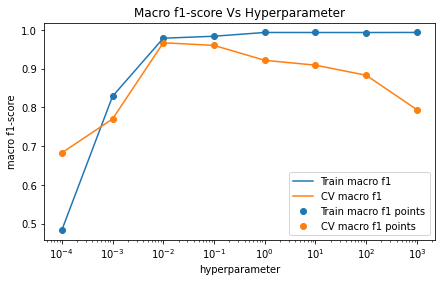

In [98]:
# plotting cross validation result
get_cv_plot(clf, 'param_C')

In [99]:
#Logs gridsearchcv to MlFlow
#log_results(clf, 'lr_gridcv', "lr_1", {"versione":"1" }, False)

In [100]:
clf.best_params_

{'C': 0.01}

In [101]:
# C: Inverse of regularization strength
param_C = 1000

Macro F1-Score:0.9208 

Confusion Matrix


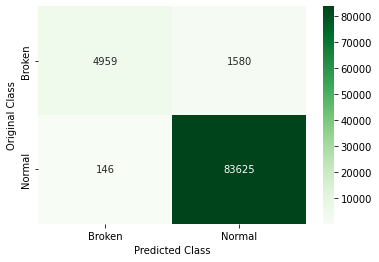

In [102]:
# traing with best C value
log_reg = LogisticRegression(C=param_C, n_jobs=-1, random_state=21)
log_reg.fit(X_train, y_train)
get_result(log_reg, X_test, y_test)

Observations:
- Macro F1-Score of 0.9837 is obtained
- Model correctly classified 83496 Normal class data points and 5469 Broken class data points
- Model misclassified 275 Normal class data points as Broken and 70 Broken class data points as Normal
- Total misclassification count is 345


#### SVM

In [103]:
# svm model
svm_clf = SGDClassifier(loss='hinge', penalty='l2', n_jobs=-1, random_state=21)

# parameter to tune
# alpha: regularization strength
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# defining model to tune hyperparameter
svm_cv = GridSearchCV(estimator=svm_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit the model to train data
svm_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SGDClassifier(n_jobs=-1, random_state=21), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='f1_macro')

In [104]:
# Logs gridsearchcv to MlFlow
#log_results(svm_cv, 'svm_gridcv', "svm_1", {}, True)

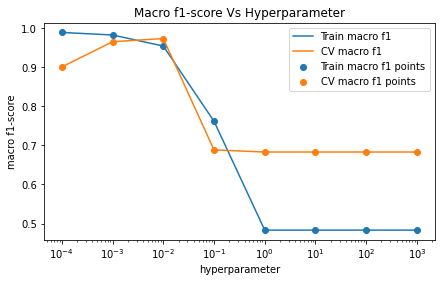

In [105]:
# plotting cross validation result
get_cv_plot(svm_cv, 'param_alpha')

best_params_Observations:
- for alpha = 0.01 both train and cross validation metric (macro f1_score) is high
- best parameter alpha = 0.01

In [106]:
svm_cv.best_params_

{'alpha': 0.01}

In [107]:
# alpha: regularization strength
param_alpha = 0.01

Training

Macro F1-Score:0.9711 

Confusion Matrix


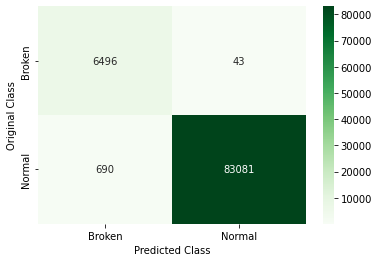

In [108]:
# traing with best alpha value
svm_clf = SGDClassifier(loss='hinge', alpha=param_alpha, penalty='l2', 
                        n_jobs=-1, random_state=21)
svm_clf.fit(X_train, y_train)

get_result(svm_clf, X_test, y_test)

Observations:
- Macro F1-Score of 0.964 is obtained
- Model correctly classified 83016 Normal class data points and 5501 Broken class data points
- Model misclassified 755 Normal class data points as Broken and 38 Broken class data points as Normal
- Total misclassification count is 793

#### Random Forest:

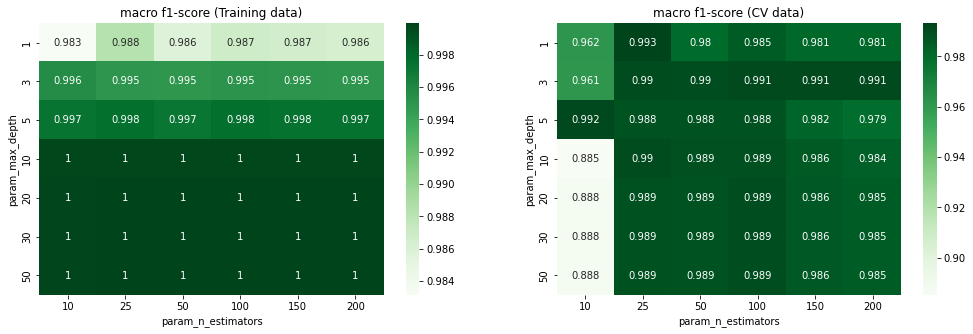

In [109]:
# random forest model
r_forest_clf = RandomForestClassifier(criterion='gini', 
                                      random_state=21, 
                                      n_jobs=-1)

# parameter to tune
# n_estimators: number of estimators
# max_depth: maximum depth of the tree
param_grid = {'n_estimators': [10, 25, 50, 100, 150, 200],
                'max_depth': [1, 3, 5, 10, 20, 30, 50]}

# defining model to tune hyperparameter
r_forest_cv = GridSearchCV(estimator=r_forest_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

r_forest_cv.fit(X_train, y_train)

# plotting cross validation result
get_cv_heatmap(r_forest_cv)

In [110]:
r_forest_cv.best_params_

{'max_depth': 1, 'n_estimators': 25}

In [111]:
#Logs gridsearchcv to MlFlow
#log_results(r_forest_cv, 'rf_gridcv', "rf_1", {"versione":"1" }, False)

Observations:
- From the heatmap optimum values are considered
- Optimum max_depth = 5
- Optimum n_estimators = 25


In [112]:
# max_depth: maximum depth of the tree
max_depth = 3
# n_estimators: number of estimators
n_estimator = 10

Training

Macro F1-Score:0.9968 

Confusion Matrix


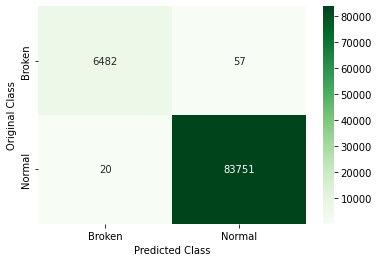

In [113]:
# traing with optimum tree depth and number of estimators
r_forest_clf = RandomForestClassifier(n_estimators = n_estimator,
                                      criterion='gini', 
                                      max_depth = max_depth,
                                      random_state=21,
                                      n_jobs=-1)

r_forest_clf.fit(X_train, y_train)

get_result(r_forest_clf, X_test, y_test)

Observations:
- Macro F1-Score of 0.9968 is obtained
- Model correctly classified 83762 Normal class data points and 5481 Broken class data points
- Model misclassified 9 Normal class data points as Broken and 58 Broken class data points as Normal
- Total misclassification count is 67

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

#### XGBoost


In [114]:
# XGBoost classifier
xgb_clf = XGBClassifier()

# parameter to tune
# n_estimators: number of estimators
# max_depth: maximum depth of the tree
param_grid = {'n_estimators': [5, 10, 20, 30, 40, 50],
                'max_depth': [1, 3, 5, 7, 10, 20, 30]}

# defining model to tune hyperparameter
xgb_cv = GridSearchCV(estimator=xgb_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit model to train data
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 10, 20, 30],
                         'n_estimators': [5, 10, 20, 30, 40, 50]},
             return_train_score=True, scoring='f1_macro')

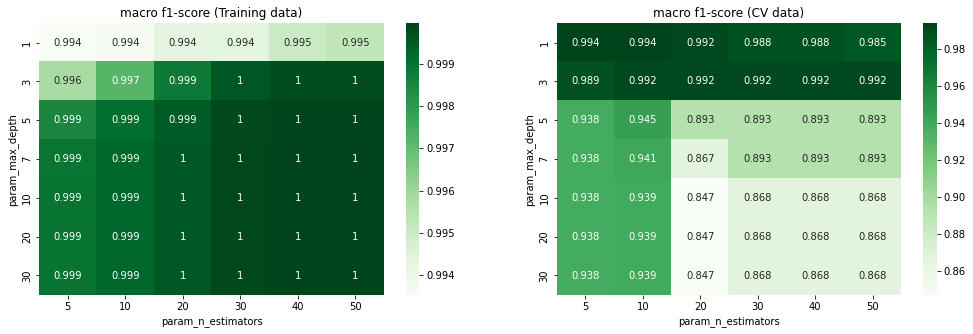

In [115]:
# plotting cross validation result
get_cv_heatmap(xgb_cv)

In [116]:
# Logs gridsearchcv to MlFlow
#log_results(xgb_cv, "xgb_gridcv", "xgb_1", {"versione":"1" }, False)

Observations:
- From the heatmap optimum values are considered
- Optimum max_depth = 1
- Optimum n_estimators = 5

Training:

In [117]:
xgb_cv.best_params_

{'max_depth': 1, 'n_estimators': 5}

In [118]:
# optimum parameters
max_depth = 5
n_estimator = 10

In [119]:
# traing with optimum tree depth and number of estimators
xgb_clf = XGBClassifier(n_estimators=n_estimator, max_depth=max_depth)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Macro F1-Score:0.9924 

Confusion Matrix


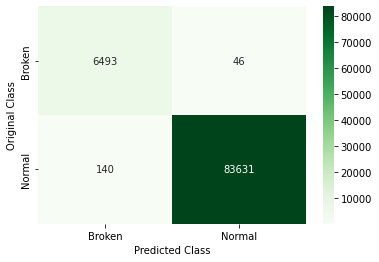

/home/cdsw/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cdsw/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

In [120]:
get_result(xgb_clf, X_test, y_test)

Observations:
- Macro F1-Score of 0.9963 is obtained
- Model correctly classified 83760 Normal class data points and 5474 Broken class data points
- Model misclassified 11 Normal class data points as Broken and 65 Broken class data points as Normal
- Total misclassification count is 76